# Premise
It's about time we actually created a system to verify whether our strategies are actually proficient in predicting price movements. Basically, at this point I can't really trust the methods I've been using to gauge how much we will buy or sell a given stock for, and therefore I can't really rely on my training set until I get a second opinion. We need to establish ground truth.

## Schema Agnostic Method
We must thus develop a schema agnostic method by which to test our hypotheses. There will be the following signals in our method:
1. Market Entry: This is a precise index at which point we are to enter the market, either long or short depending on the method.
2. Market Exit: This is an optional point at which we would exit the market regardless of earnings (your atr failsafes, etc)

Using these signals we will record how much the price rose since the entry point to the exit point, and how much it fell, and then compare with whether or not the result would be positive for us. If there is no exit point given then the exit point will simply be the next entry point.

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import metadata.trade_configs.Globals as gb
import alpaca_trade_api as alp
import lib.tools.TimeKeeper as tk
import lib.tools.Scrivener as sc
import lib.tools.Logger as log
import lib.tools.Broker as br
import lib.tools.Toolbox as tb
import numpy as np
import os.path as p
import alpaca_trade_api
import pandas as pd
import pytz
import glob
import re

from lib.RoboTrader import RoboTrader
from lib.tools.Config import Config
from lib.strategies.MomentumSeeking import MomentumSeeking
from lib.selectors.SimpleSelection import SimpleSelection

# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial Outline
1. Create method to pull all data from entire archive by day
2. Create method that recreates the entry points for momentumseeking
3. Create method which judges the effectiveness of entry points for a given set of parameters
4. Perform analysis to determine ideal settings and viability for each symbol

## PULL ALL ENTRIES

In [ ]:
class EntryPuller:
    def __init__(self, symbol:str):
        self.symbol = symbol
        self.all_days = [re.search('\d\d\d\d-\d\d-\d\d', line).group() for line in glob.glob('../stock_archive/processed/'+symbol+'/10_*')]
        for i in range(len(self.all_days)):
            day = self.all_days[i].split('-')
            self.all_days[i] = tk.d(int(day[1]),int(day[2]),year=int(day[0]))

    def get_data(self, date:pd.Timestamp):
        '''Gets the data of a given day from the symbol'''
        return sc.get_archive(self.symbol, date)

# Contemplations
We are in a bit of a pickle. Our strategies go through periods of effectiveness and it's hard to say what underlies those periods. We ought to investigate this matter further, but it's unclear where to start. For now we're going to try to put some rudimentary stock advice into practice.

1. Create method to find peaks and valleys
2. Create simple formula to remember previous peaks and values and then check if we have crossed our threshold

# Local Minima and Maxima

In [3]:
df = sc.get_archive('NVDA', tk.d(4,29))
# tb.candle_plot(df, title='Data without Maxima and Minima', show=True)

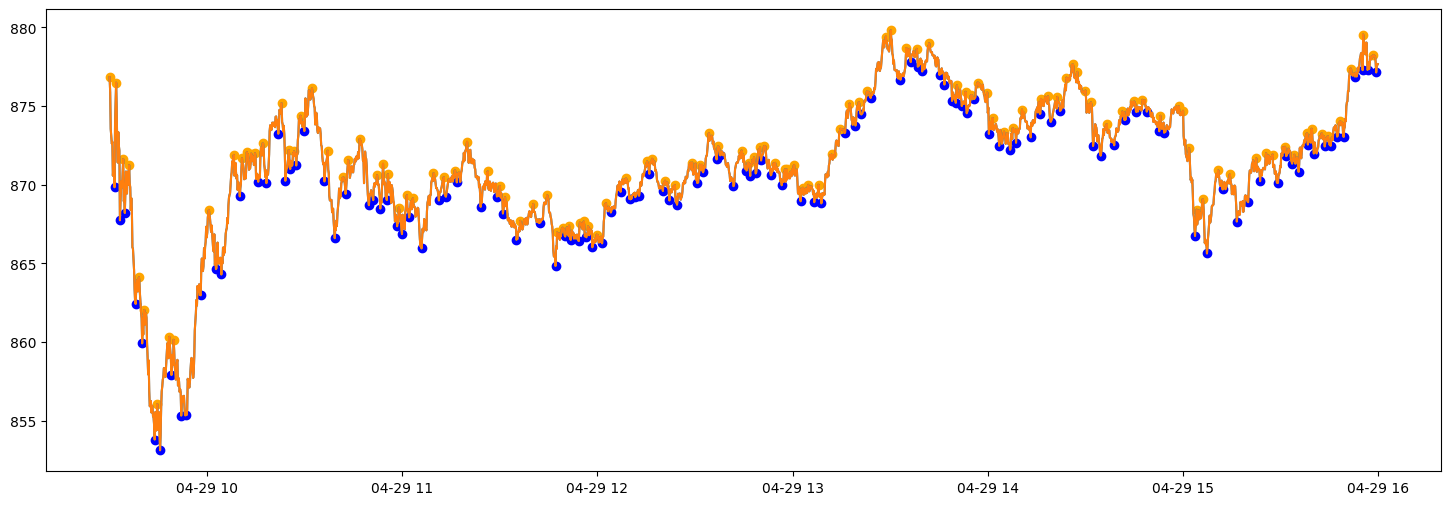

In [5]:
from scipy.signal import argrelextrema
n = 6
def plot_minima_and_maxima(series:pd.Series):
    plt.close()
    plt.figure(figsize=(18, 6), dpi=100)
    plt.plot(series.index, series)
    mi = series.iloc[argrelextrema(series.values, np.less_equal,
                        order=n)[0]]
    ma = series.iloc[argrelextrema(series.values, np.greater_equal,
                        order=n)[0]]

    # Plot results
    plt.scatter(mi.index, mi.values, c='blue')
    plt.scatter(ma.index, ma.values, c='orange')
    plt.plot(series.index, series)
    plt.show()
plot_minima_and_maxima(df.close)

# INITIAL TREND DETECTION ATTEMPT

/tmp/ipykernel_3376/2003329854.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1
/tmp/ipykernel_3376/2003329854.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1
/tmp/ipykernel_3376/2003329854.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a val

None


/tmp/ipykernel_3376/2003329854.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1
/tmp/ipykernel_3376/2003329854.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1


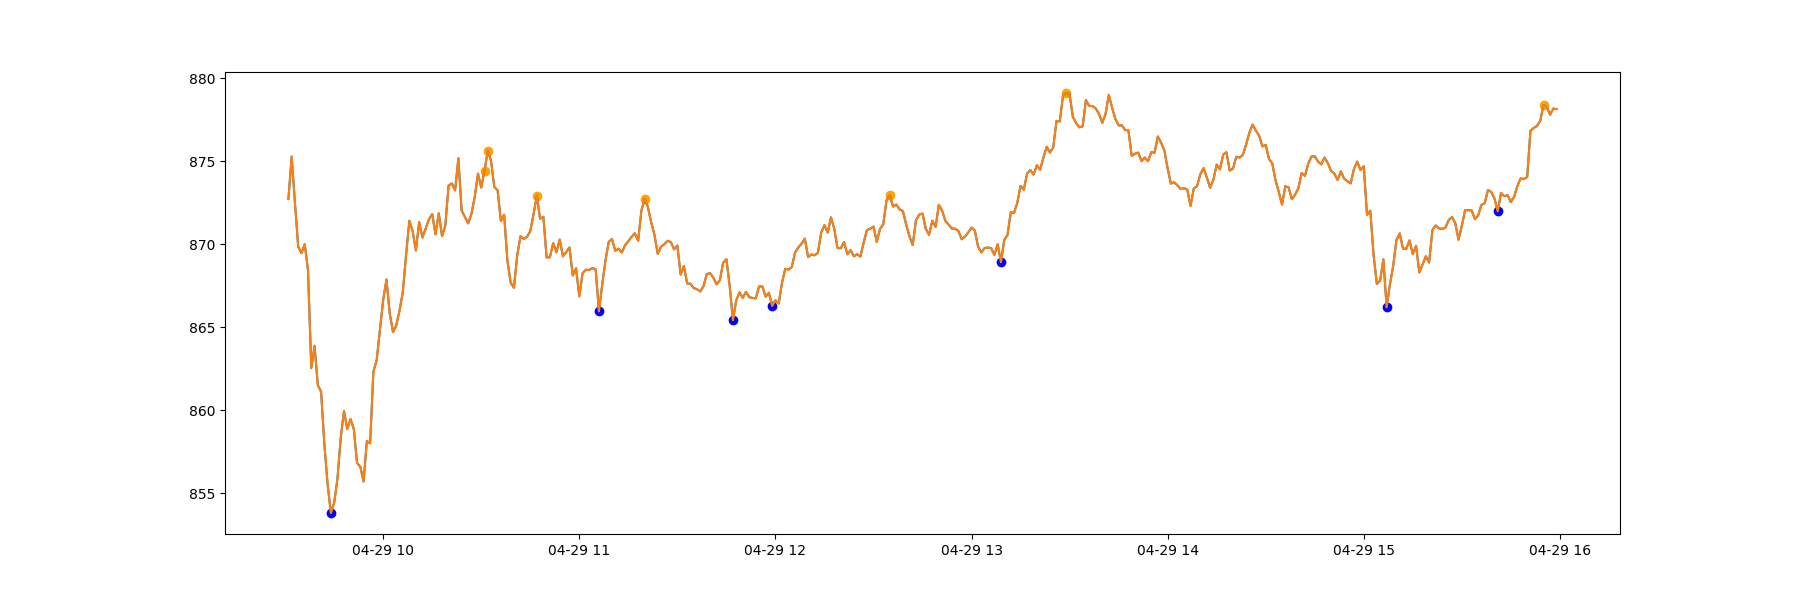

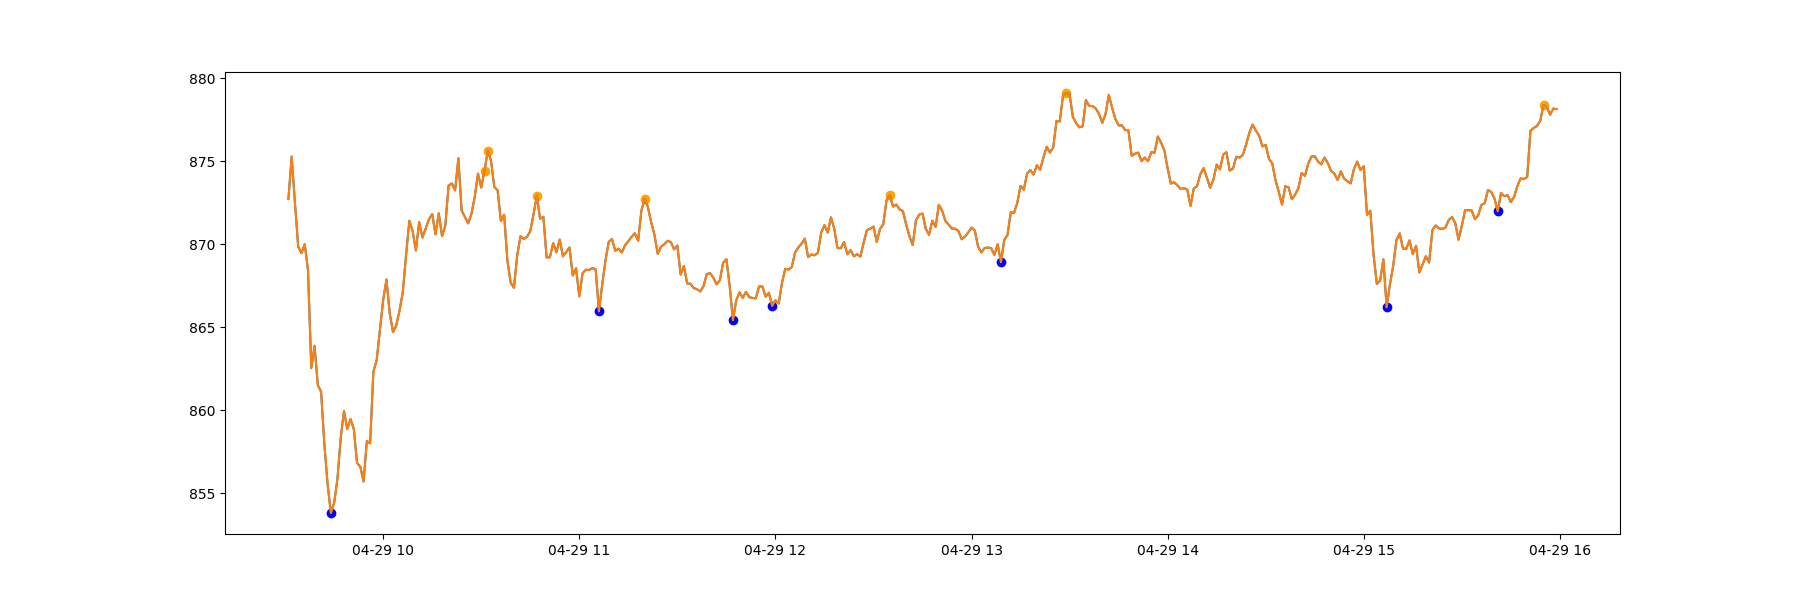

In [7]:
class TrendWatcher:
    def __init__(self, series:pd.Series, index:pd.DatetimeIndex):
        self.series, self.n = series, 5
        self.aspirant_max, self.aspirant_min = None, None
        self.true_max, self.true_min = pd.Series([]), pd.Series([])
        self.backfill(index)
        #self.check_trend()
    
    def get_local_maxima_and_minima(self, index:pd.DatetimeIndex):
        '''Returns two lists of the local maxima and minima'''
        maxima = self.series.iloc[argrelextrema(self.series[:index].values, np.greater_equal, order=self.n)[0]]
        minima = self.series.iloc[argrelextrema(self.series[:index].values, np.less_equal, order=self.n)[0]]
        return maxima, minima

    def backfill(self, index:pd.DatetimeIndex):
        '''Backfills the trend data up to the given index (so as to bring the trend up to current)'''
        maxima, minima = self.get_local_maxima_and_minima(index)
        self.true_max.loc[maxima.index[0]], self.true_min.loc[minima.index[0]] = maxima.iloc[0], minima.iloc[0]
        start = maxima.index[0] if maxima.index[0] > minima.index[0] else minima.index[0]
        for index in self.series[start:index].index: self.update(index)
        self.plot(index)
        print(self.aspirant_min)

    def update(self, index:pd.DatetimeIndex):
        '''Updates the trend for the current index'''
        maxima, minima = self.get_local_maxima_and_minima(index)
        value = self.series.loc[index]
        # The aspirants may ascend
        if self.aspirant_min and value > self.true_max.iloc[-1]: self.true_min.loc[self.aspirant_min] = self.series.loc[self.aspirant_min]; self.aspirant_min = None
        if self.aspirant_max and value < self.true_min.iloc[-1]: self.true_max.loc[self.aspirant_max] = self.series.loc[self.aspirant_max]; self.aspirant_max = None

        if index in maxima:
            if maxima.loc[index] > self.true_max.iloc[-1]: self.true_max.drop(self.true_max.index[-1], inplace=True); self.true_max.loc[index] = maxima.loc[index]
            else: self.aspirant_max = index
        elif index in minima:
            if minima.loc[index] < self.true_min.iloc[-1]: self.true_min.drop(self.true_min.index[-1], inplace=True); self.true_min.loc[index] = minima.loc[index]
            else: self.aspirant_min = index

        if len(self.true_max) <= 2 and len(self.true_min) <= 2: return 0
        if self.true_max.iloc[-2] < self.true_max.iloc[-1] and self.true_min.iloc[-2] < self.true_min[-1]: return 1
        elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1
        else: return 0
    
    def plot(self, index:pd.DatetimeIndex = None):
        if not index: index = self.series.index[-1]
        series = self.series[:index]

        plt.figure(figsize=(18, 6), dpi=100)
        plt.plot(series.index, series)

        # Plot results
        plt.scatter(self.true_max.index, self.true_max.values, c='orange')
        plt.scatter(self.true_min.index, self.true_min.values, c='blue')

        # valleys, peaks = self.get_local_maxima_and_minima(index)
        # plt.scatter(valleys.index, valleys.values, c='blue')
        # plt.scatter(peaks.index, peaks.values, c='orange')
        plt.plot(series.index, series)
        #plt.show()

t = TrendWatcher(df.close, tk.d(4,30,10,10))
t_lines = []
for index in df[tk.d(4,30,10,10):].index:
    t_lines.append([index, t.update(index)])
t.plot()
for t_line in t_lines:
    if t_line[1] == 1: plt.axvline(t_line[0], color='green', alpha=.25)
    elif t_line[1] == -1: plt.axvline(t_line[0], color='red', alpha=.25)
    elif t_line[1] == 0: plt.axvline(t_line[0], color='yellow', alpha=.25)
# print(t.up_trend)

# SECOND ATTEMPT ESCHEWING MAXIMA AND MINIMA

In [1]:
from enum import Enum

'''
At each step we run a function called "update"
    That function looks at the current value and compares it to the last confirmed min or max. If it is beyond the last confirmed min or max the current aspiring min or max is added to the list
    
    Ok ok, so update notices that we are sitting on a maxima:
        if it is above the last maxima then we add it to confirmed_maxima
        otherwise we set it as the aspirant
        The aspirant is only confirmed if the low goes below the last confirmed minima
'''

class TrendWatcher:
    def __init__(self, series:pd.Series, index:pd.DatetimeIndex):
        self.series, self.n = series, 5
        self.aspirant_max, self.aspirant_min = None, None
        self.reigning_max, self.reigning_min = series.index[0], series.index[0]
        self.confirmed_maxima, self.confirmed_minima = pd.Series([]), pd.Series([])
        self.backfill(index)
        #self.check_trend()

    def backfill(self, index:pd.DatetimeIndex):
        '''Backfills the trend data up to the given index (so as to bring the trend up to current)'''
        for index in self.series[:index].index: self.update(index)
        self.plot(index)
        print(self.aspirant_min)

    def update(self, index:pd.DatetimeIndex):
        '''Updates the trend for the current index'''
        value = self.series.loc[index]

        # The aspirants may ascend
        if self.aspirant_min and value > self.series.loc[self.reigning_max]:
            self.confirmed_minima.loc[self.reigning_min] = self.series.loc[self.reigning_min]
            self.reigning_min, self.aspirant_min = self.aspirant_min, None
        if self.aspirant_max and value < self.series.loc[self.reigning_min]:
            self.confirmed_maxima.loc[self.reigning_max] = self.series.loc[self.reigning_max]
            self.reigning_max, self.aspirant_max = self.aspirant_max, None

        if value > self.series.loc[self.reigning_max]: self.aspirant_max = index
        elif value < self.series.loc[self.reigning_min]: self.aspirant_min = index

        # if len(self.true_max) <= 2 and len(self.true_min) <= 2: return 0
        # if self.true_max.iloc[-2] < self.true_max.iloc[-1] and self.true_min.iloc[-2] < self.true_min[-1]: return 1
        # elif self.true_max.iloc[-2] > self.true_max.iloc[-1] and self.true_min.iloc[-2] > self.true_min[-1]: return -1
        # else: return 0
    
    def plot(self, index:pd.DatetimeIndex = None):
        if not index: index = self.series.index[-1]
        series = self.series[:index]

        plt.figure(figsize=(18, 6), dpi=100)
        plt.plot(series.index, series)

        # Plot results
        plt.scatter(self.confirmed_maxima.index, self.confirmed_maxima.values, c='orange')
        plt.scatter(self.confirmed_minima.index, self.confirmed_minima.values, c='blue')

        # valleys, peaks = self.get_local_maxima_and_minima(index)
        # plt.scatter(valleys.index, valleys.values, c='blue')
        # plt.scatter(peaks.index, peaks.values, c='orange')
        plt.plot(series.index, series)
        #plt.show()

t = TrendWatcher(df.close, tk.d(4,30,10,10))
t_lines = []
for index in df[tk.d(4,30,10,10):].index:
    t_lines.append([index, t.update(index)])
t.plot()
for t_line in t_lines:
    if t_line[1] == 1: plt.axvline(t_line[0], color='green', alpha=.25)
    elif t_line[1] == -1: plt.axvline(t_line[0], color='red', alpha=.25)
    elif t_line[1] == 0: plt.axvline(t_line[0], color='yellow', alpha=.25)
# print(t.up_trend)

NameError: name 'pd' is not defined

1. The first peak and valley are confirmed automatically
2. Following peaks and valleys are only confirmed if one of these happens:
    a. The price moves beyond their opposite last confirmed point (the threshold)
    b. They move beyond the last same point

# Attempting with EWM and ADX

In [51]:
import numpy as np
adx = tb.get_adx(df)
for index in adx.index:
    print(index, adx.loc[index])

2024-04-29 09:30:10-04:00 nan
2024-04-29 09:30:20-04:00 nan
2024-04-29 09:30:30-04:00 nan
2024-04-29 09:30:40-04:00 nan
2024-04-29 09:30:50-04:00 nan
2024-04-29 09:31:00-04:00 nan
2024-04-29 09:31:10-04:00 nan
2024-04-29 09:31:20-04:00 nan
2024-04-29 09:31:30-04:00 nan
2024-04-29 09:31:40-04:00 nan
2024-04-29 09:31:50-04:00 nan
2024-04-29 09:32:00-04:00 nan
2024-04-29 09:32:10-04:00 nan
2024-04-29 09:32:20-04:00 nan
2024-04-29 09:32:30-04:00 nan
2024-04-29 09:32:40-04:00 nan
2024-04-29 09:32:50-04:00 nan
2024-04-29 09:33:00-04:00 nan
2024-04-29 09:33:10-04:00 nan
2024-04-29 09:33:20-04:00 nan
2024-04-29 09:33:30-04:00 nan
2024-04-29 09:33:40-04:00 nan
2024-04-29 09:33:50-04:00 nan
2024-04-29 09:34:00-04:00 nan
2024-04-29 09:34:10-04:00 nan
2024-04-29 09:34:20-04:00 nan
2024-04-29 09:34:30-04:00 nan
2024-04-29 09:34:40-04:00 nan
2024-04-29 09:34:50-04:00 nan
2024-04-29 09:35:00-04:00 20.226157112986023
2024-04-29 09:35:10-04:00 19.65729984633595
2024-04-29 09:35:20-04:00 19.129075241589

In [46]:
df = sc.get_archive('NVDA', tk.d(4,29))
adx = get_adx(df.high, df.low, df.close)
ema = pd.Series(get_ema(df.close))

/tmp/ipykernel_3376/987820873.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  offset = arr[0]*pows[1:]


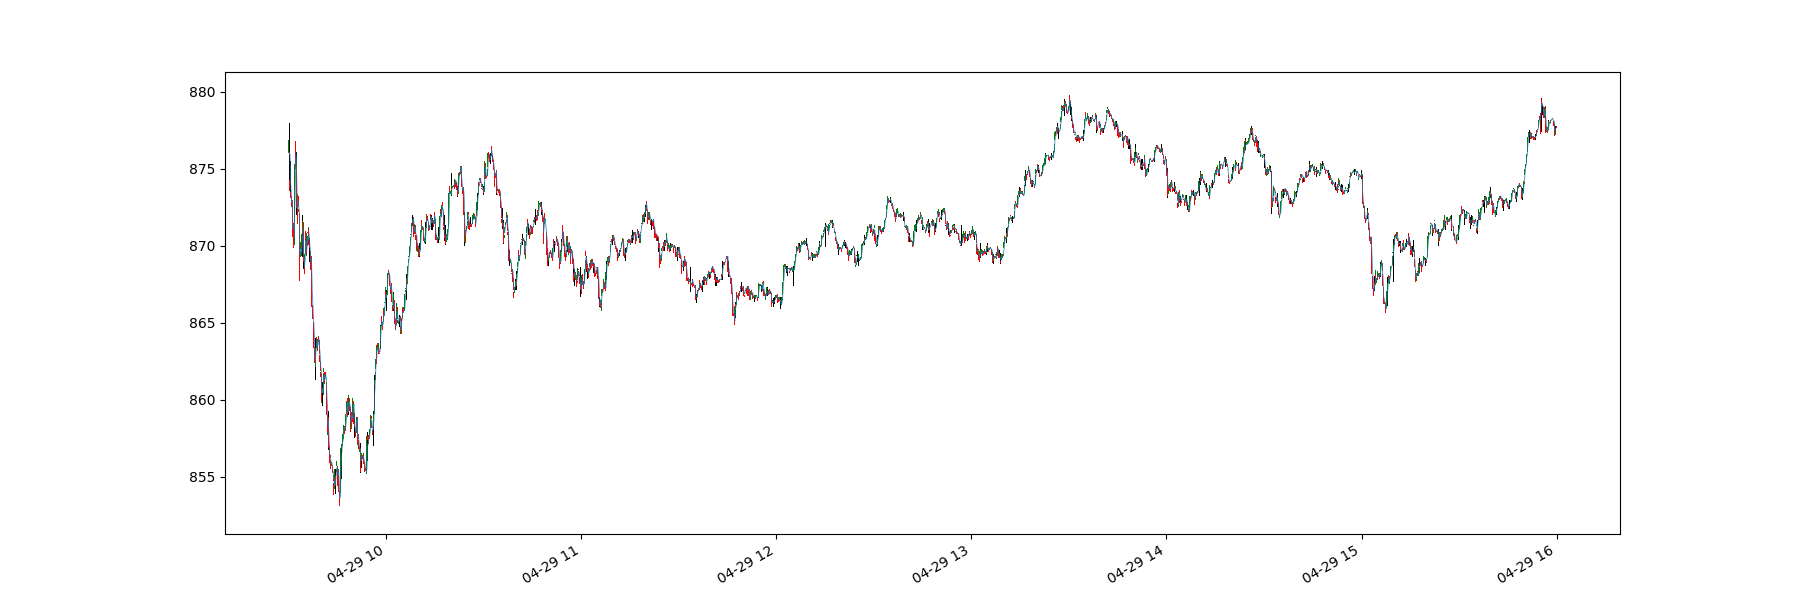

/tmp/ipykernel_3376/2863659118.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(delta[i]) or np.isnan(adx[i]): continue
/tmp/ipykernel_3376/2863659118.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if delta[i] < 0: plt.axvline(df.index[i], color='red', lw=2, alpha=adx[i]/100)
/tmp/ipykernel_3376/2863659118.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if delta[i] > 0: plt.axvline(df.index[i], color='green',

In [52]:
tb.candle_plot(df, show=True)
plt.plot(df.index, ema)
delta = ema.diff()
for i in range(len(df)):
    if np.isnan(delta[i]) or np.isnan(adx[i]): continue
    if delta[i] > 0: plt.axvline(df.index[i], color='green', lw=2, alpha=adx[i]/100)
    if delta[i] < 0: plt.axvline(df.index[i], color='red', lw=2, alpha=adx[i]/100)


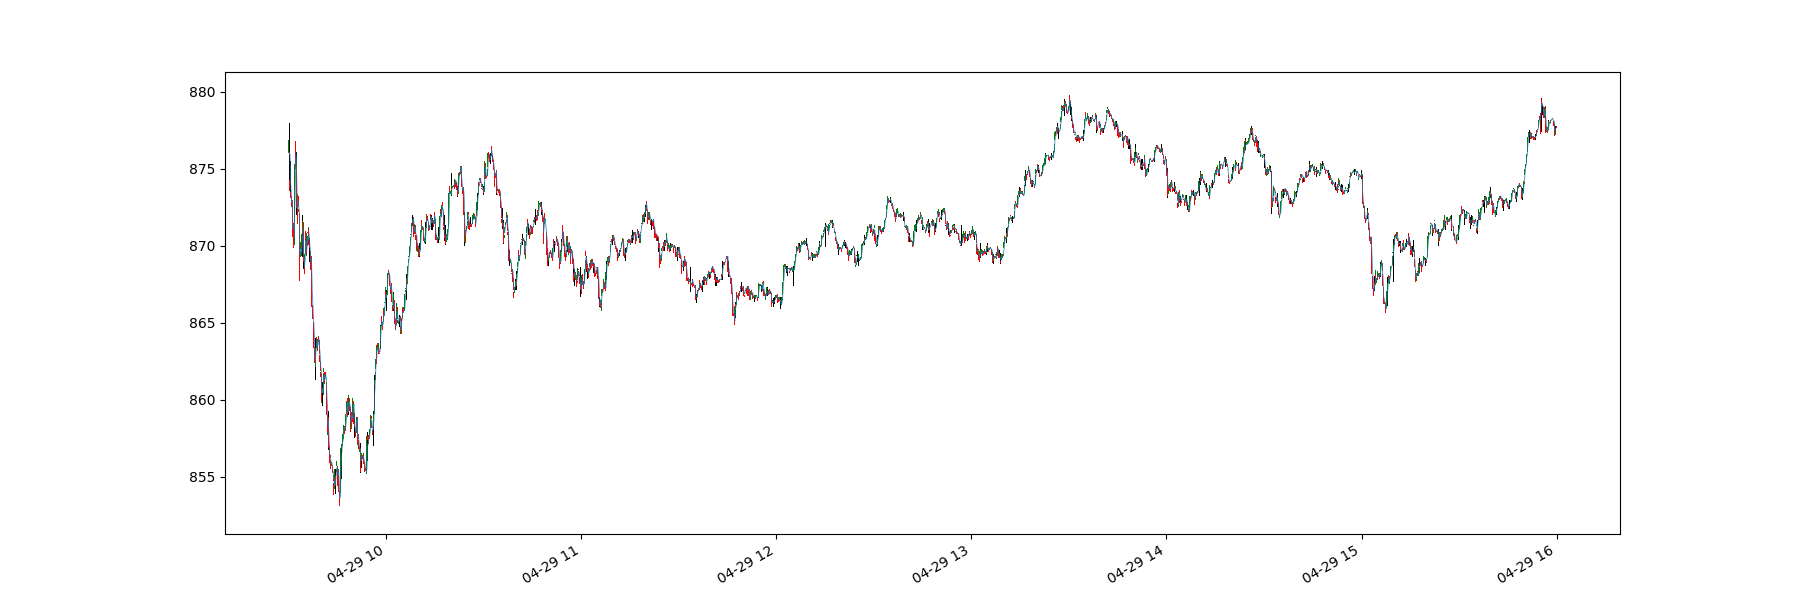

In [47]:
tb.candle_plot(df, show=True)
plt.plot(df.index, ema)
delta = ema.diff()
for i in range(len(df)):
    if np.isnan(delta[i]) or np.isnan(adx[i]): continue
    if delta[i] > 0: plt.axvline(df.index[i], color='green', lw=2, alpha=adx[i]/100)
    if delta[i] < 0: plt.axvline(df.index[i], color='red', lw=2, alpha=adx[i]/100)

# Long Term Viability Testing (i.e, what factors/indicators make a stock tradeable?)
Let's get some experimental design going. What are the steps of the scientific method? Observation, Inquery, Hypothesis, Prediction, Experiment, Reflection, which is to say OIHPER. So:
1. Observation: There seem to be periods where our method doesn't work consistently on stocks, and periods where it do.
2. Inquiry: What factors lead to the above observation.
3. Hypothesis: A number of technical factors, such as the OBV or RSI, or simply values, such as delta or volume, are causitive of our algorithm's success.
4. Prediction: Using these factors, I will be able to judge whether a stock works with my method, or does not.
5. Experiment: I will test this by running through the stocks that should be good for my method in the backtesting module.
6. Reflection: TBD

We are on average losing money until WEDNESDAY 2/7 for NVDA

### Testing the Hypothesis

In [41]:
# Helper Functions
def plot_graph(series, title, color='blue', results = None):
    plt.figure(figsize=(18, 6), dpi=100)
    plt.title(title)
    tb.qp(series, color)
    if isinstance(results, pd.DataFrame):
        for index in results.index:
            if results.profit.loc[index] > 0: plt.axvline(index, color='green',lw=.5)
            if results.profit.loc[index] < 0: plt.axvline(index, color='red',lw=.5)
    plt.show()

# DEFINE TUNING
symbols = ['NVDA']

def tuning(symbols, days, logging:bool = False, show:bool = False, write:bool = False, selector=SimpleSelection, strategy=MomentumSeeking, s:pd.Timestamp = None, e:pd.Timestamp = None):
    '''Runs a stock experiment on the given range of days. Days should be a negative number for how far back you want to look'''

    log.ENABLE_LOGGING = logging
    
    if isinstance(days, pd.Timestamp): dates = [days]
    elif isinstance(days, list): dates = days
    elif s and not e:
        dates = pd.date_range(start=s, end=tk.today(), freq='B')
        dates = dates[days:] if tk.is_after(gb.TRADE_START_HOUR, gb.TRADE_START_MINUTE, tk.now()) else dates[days-1:len(dates)-1]
    elif s and e:
        dates = pd.date_range(start=s, end=e, freq='B')
    else:
        dates = pd.date_range(start=tk.today()-pd.DateOffset(days=abs(days*3)), end=tk.today(), freq='B')
        dates = dates[days:] if tk.is_after(gb.TRADE_START_HOUR, gb.TRADE_START_MINUTE, tk.now()) else dates[days-1:len(dates)-1]
    conf, final_total = Config('base'), 0

    success, failure = [], []

    results = []
    #print('Dates Covered\n',dates)
    for date in dates:
        trader = RoboTrader(None, conf, selector=selector, strategy=strategy)#, symbols=symbols)
        for symbol in symbols: log.clear_logs(None, date, symbol)
        try: tickers = trader.trade_simulation(date)
        except: print('skipping',date); continue
        # tickers = trader.trade_simulation(date)
        day_profit = trader.port.cash-100000
        #if day_profit > 0: day_profit *= 1.8
        #else: day_profit *= .554
        
        if show:
            for ticker in tickers: tickers[ticker].plot_line()
            
        results.append({'date':date, 'profit': day_profit})

        if write: print(str(date.month)+'/'+str(date.day), date.day_name(), round(day_profit,2),'\t\t',round(final_total,2))
        if len(trader.bulls) > 1:
            for symbol in trader.bulls: print('\t'+symbol+':',trader.strategies[symbol].ticker_profit)

        final_total += day_profit
    if len(results) == 0: return
    results = pd.DataFrame(results); results.set_index('date', inplace=True)

    print('\nTOTAL:',round(results.profit.sum(),2), '\nDAILY:',
      round(results.profit.mean(),2), 'over',len(results),'days')
    if len(results.profit[results.profit < 0]) > 0:
        print('\tAverage Loss:',round(results.profit[results.profit < 0].mean(),2),
      '\n\tTotal Losses:',round(results.profit[results.profit < 0].sum(),2),
      '\n\tGreatest Loss in a Day',round(results.profit[results.profit < 0].min()))
    return results

In [10]:
api, symbol = br.paper_api(), 'NVDA'
month_data = api.get_bars(symbol, alpaca_trade_api.TimeFrame.Day, start=tk.dto_time(tk.d(1,1,year=2023)), end=tk.dto_time(tk.d(6,3))).df
date_of_reversal = tk.d(2,7)

Activating with Paper


In [11]:
obv = tb.get_obv(month_data)
rsi = tb.get_rsi(month_data)
atr = tb.get_atr(month_data)
volume = month_data.volume

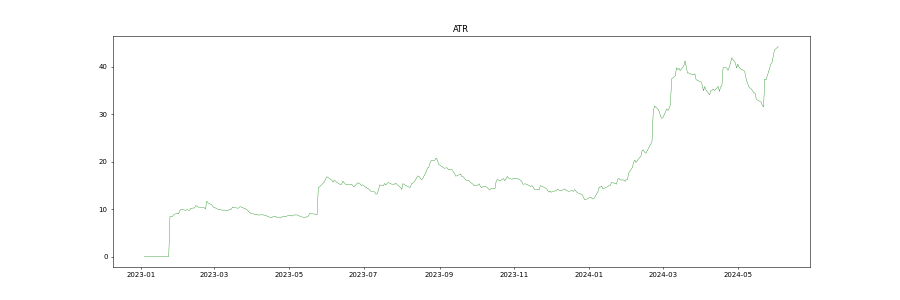

In [12]:
plot_graph(atr, 'ATR')
plt.axvline(date_of_reversal, color='red')

Updated Hypothesis: The tell is an ATR above a certain threshold of profitability. In NVDA's case that would mean an ATR above 20.
Experiment: Test the performance of 2023-08-21 through 2023-09-03 and compare it to 2023-09-03 through 2023-10-15

In [20]:
# GETTING ENMASS RESULTS
mass_results = tuning(symbols, -95, False, False, s=tk.d(1,3), e=tk.today())

skipping 2024-01-15 00:00:00-05:00
skipping 2024-02-19 00:00:00-05:00
skipping 2024-03-29 00:00:00-04:00
skipping 2024-05-27 00:00:00-04:00
skipping 2024-05-31 00:00:00-04:00
skipping 2024-06-04 00:00:00-04:00

TOTAL: 28319.72 
DAILY: 272.3 over 104 days
	Average Loss: -1245.69 
	Total Losses: -53564.66 
	Greatest Loss in a Day -3667


# Mass Results Initial Analysis

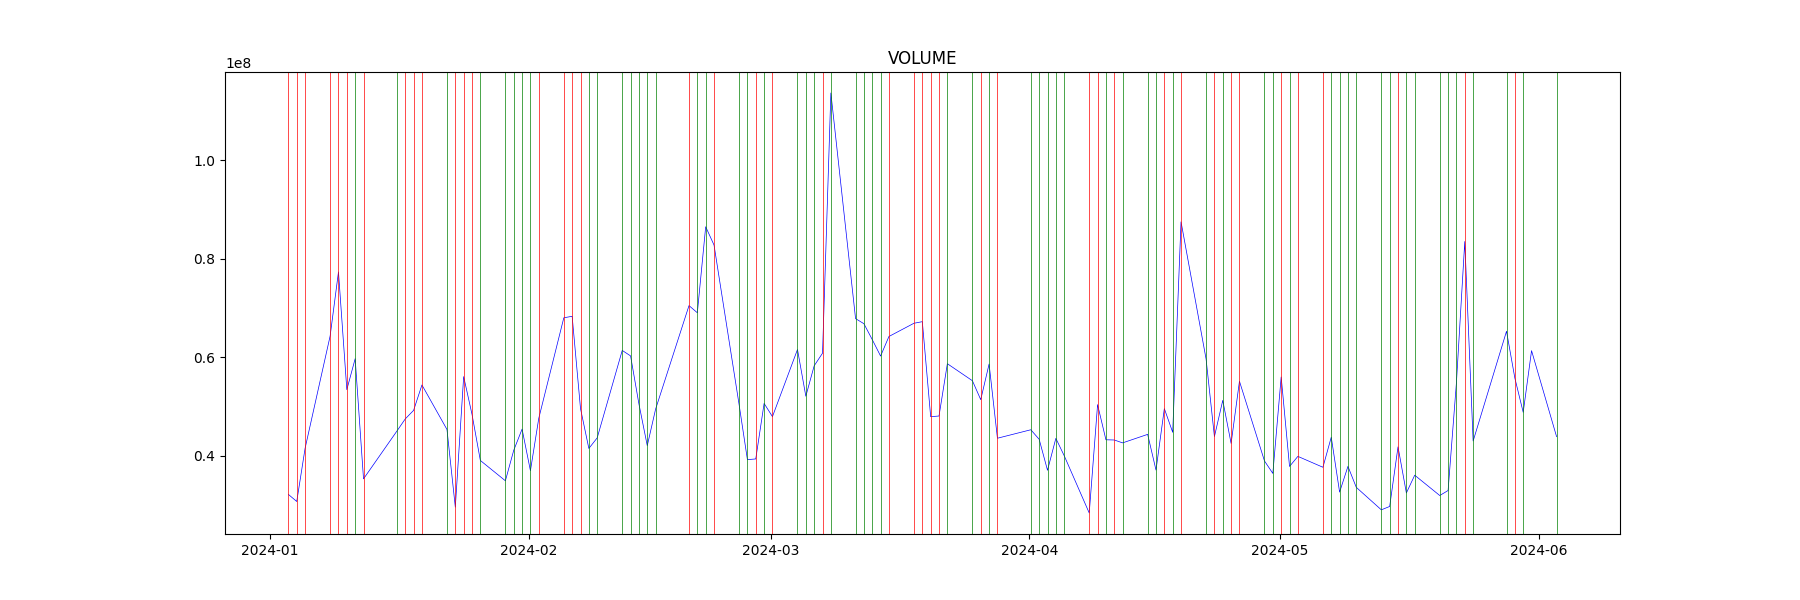

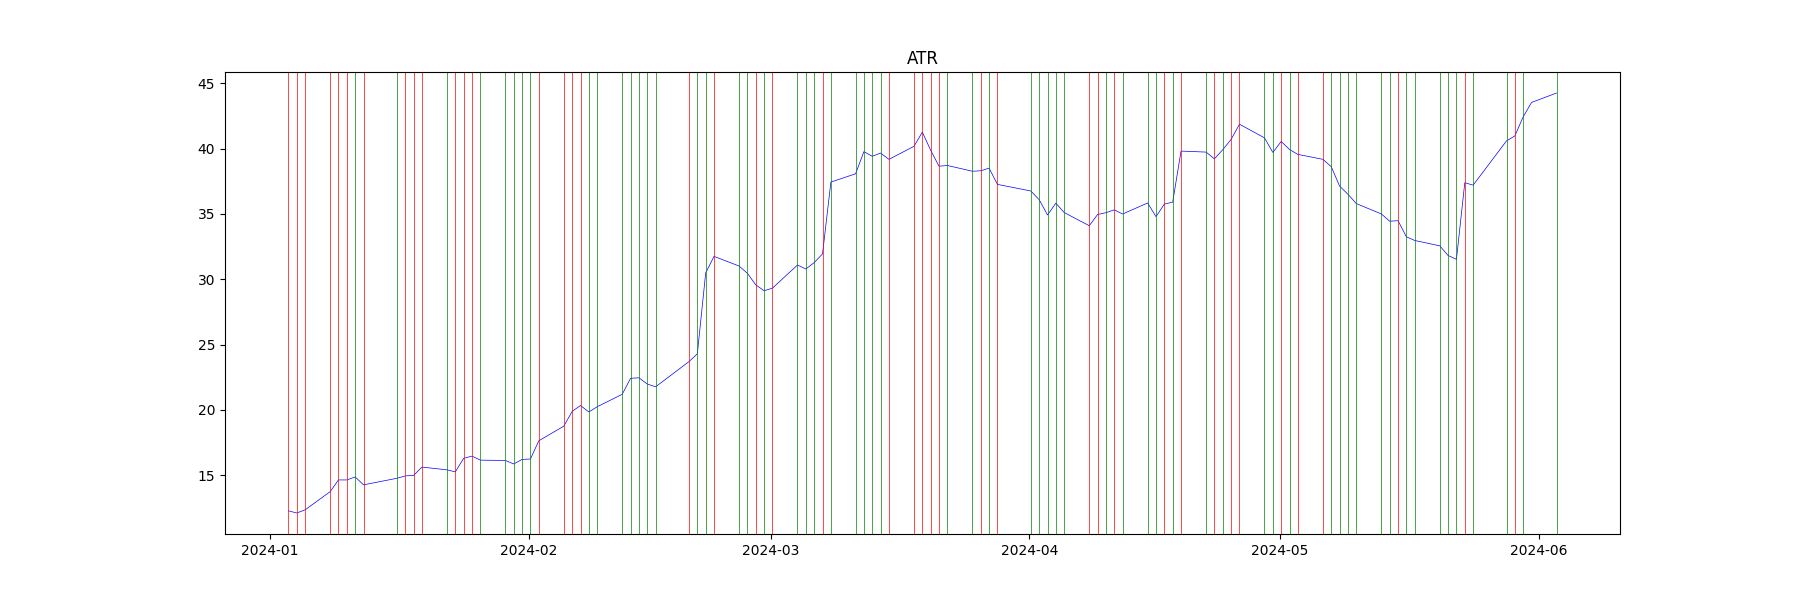

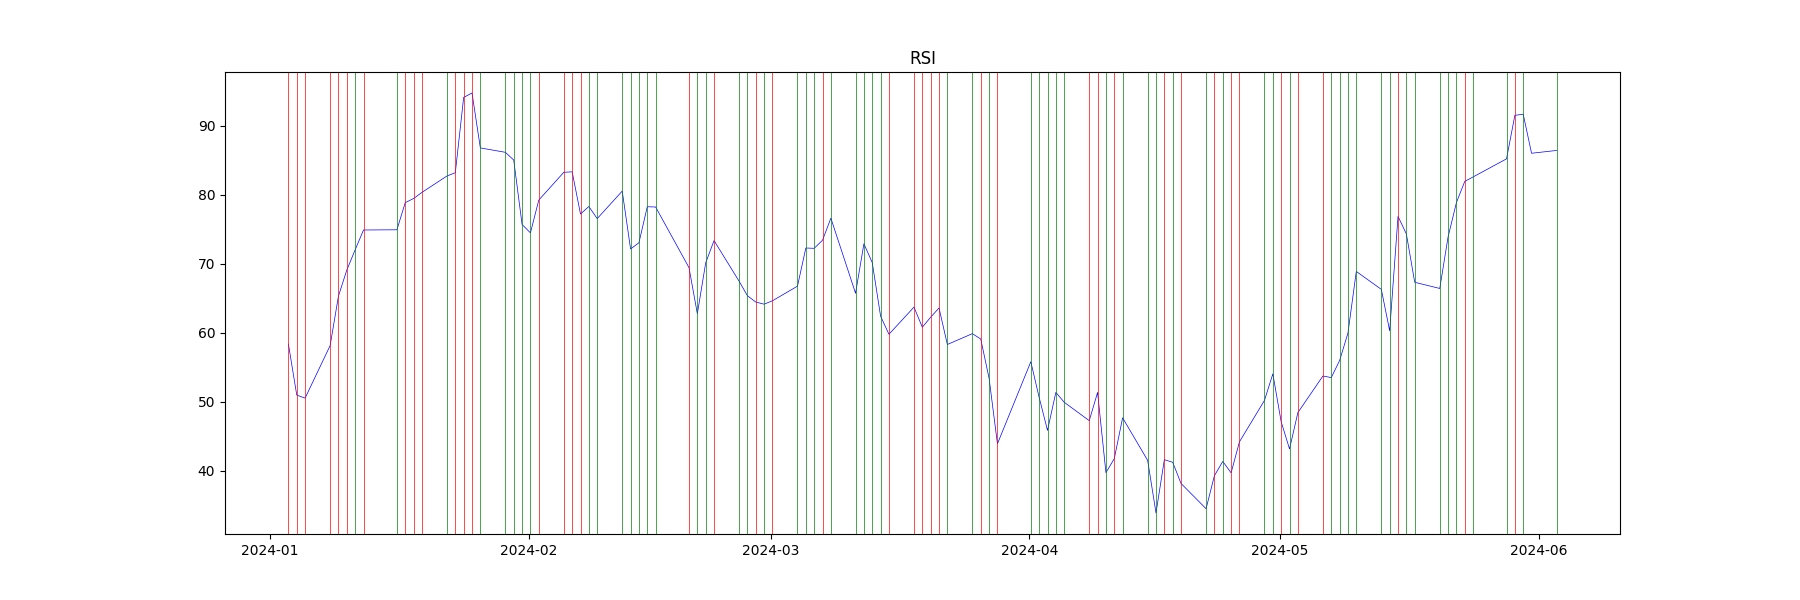

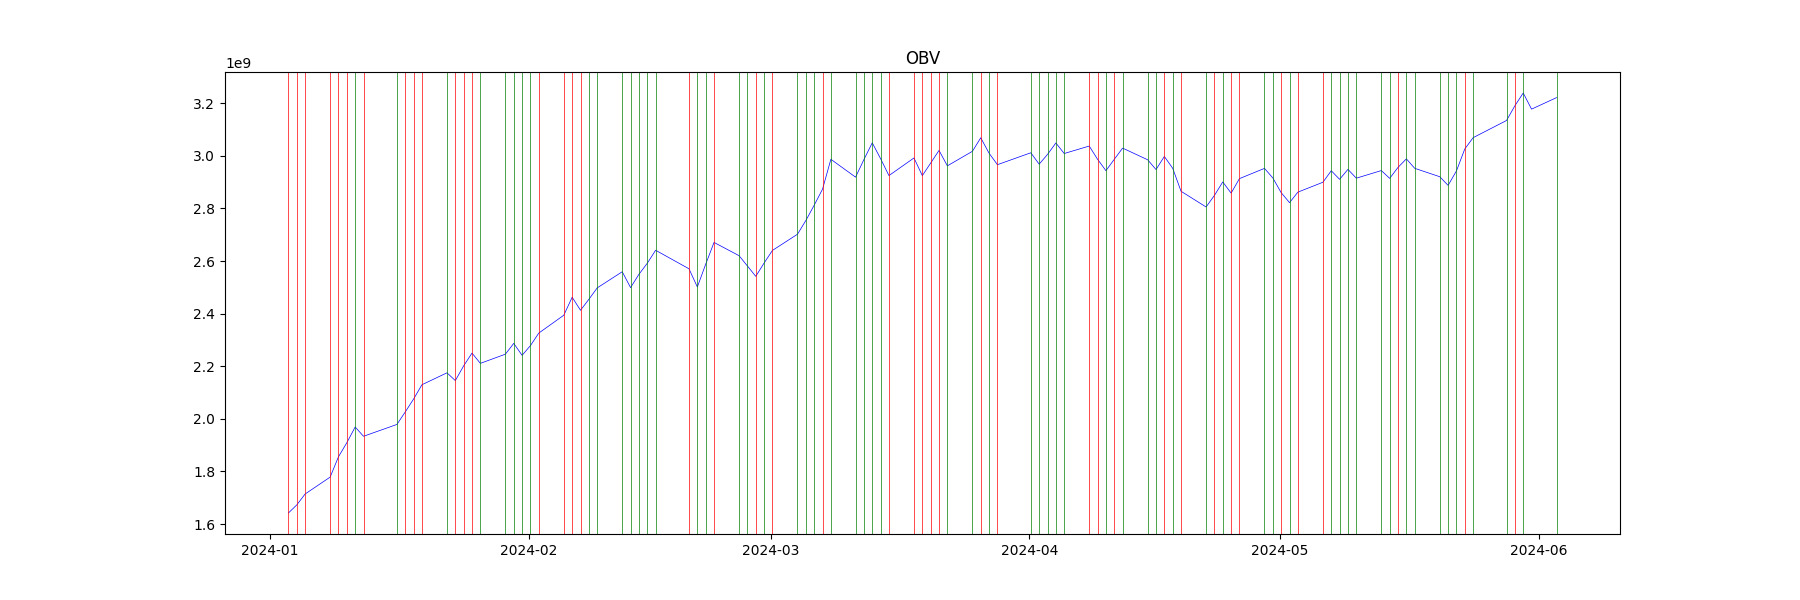

In [42]:
plot_graph(volume[mass_results.index[0]:], 'VOLUME', results=mass_results)
plot_graph(atr[mass_results.index[0]:], 'ATR', results=mass_results)
plot_graph(rsi[mass_results.index[0]:], 'RSI', results=mass_results)
plot_graph(obv[mass_results.index[0]:], 'OBV', results=mass_results)

In [24]:
# TEST FOR GOOD PERFORMANCE DURING ATR UPTICK IN AUGUST
s, e = tk.d(8,21,year=2023), tk.d(9,3,year=2023)
results = tuning(symbols, -95, False, False, s=s, e=e)
print(results)


TOTAL: -1105.18 
DAILY: -110.52 over 10 days
	Average Loss: -1078.81 
	Total Losses: -5394.05 
	Greatest Loss in a Day -3681
                              profit
date                                
2023-08-21 00:00:00-04:00    72.1803
2023-08-22 00:00:00-04:00 -3681.1994
2023-08-23 00:00:00-04:00  1070.7363
2023-08-24 00:00:00-04:00  1289.7416
2023-08-25 00:00:00-04:00  1374.3737
2023-08-28 00:00:00-04:00  -157.3251
2023-08-29 00:00:00-04:00  -479.8532
2023-08-30 00:00:00-04:00 -1023.7350
2023-08-31 00:00:00-04:00   -51.9400
2023-09-01 00:00:00-04:00   481.8404


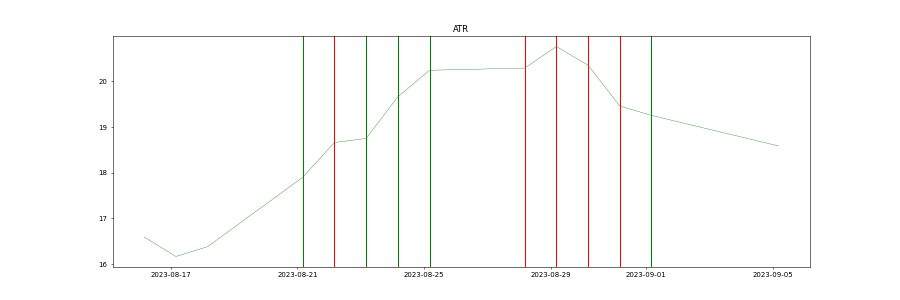

In [28]:
plot_graph(atr[s-pd.DateOffset(days=5):e+pd.DateOffset(days=2)], 'ATR', results=results)

In [51]:
# TEST FOR POOR PERFORMANCE DURING "NORMAL" ATR
s, e = tk.d(9,3,year=2023), tk.d(9,16,year=2023)
results = tuning(symbols, -95, False, False, s=s, e=e)
print(results)

Activating with Paper
Pulling trades from 2023-09-04T09:30:00-04:00 to 2023-09-04T16:00:00-04:00
skipping 2023-09-04 00:00:00-04:00

TOTAL: -336.1 
DAILY: -37.34 over 9 days
	Average Loss: -984.92 
	Total Losses: -5909.5 
	Greatest Loss in a Day -1476
                              profit
date                                
2023-09-05 00:00:00-04:00  -954.4500
2023-09-06 00:00:00-04:00  -280.7190
2023-09-07 00:00:00-04:00 -1475.8900
2023-09-08 00:00:00-04:00 -1071.3072
2023-09-11 00:00:00-04:00  -879.5156
2023-09-12 00:00:00-04:00 -1247.6200
2023-09-13 00:00:00-04:00  3086.8471
2023-09-14 00:00:00-04:00   958.3770
2023-09-15 00:00:00-04:00  1528.1740


Experimental Results: Do corraborate hypothesis, but not in a way that's particularly promising. Maybe good performance is from a change in the ATR? The 

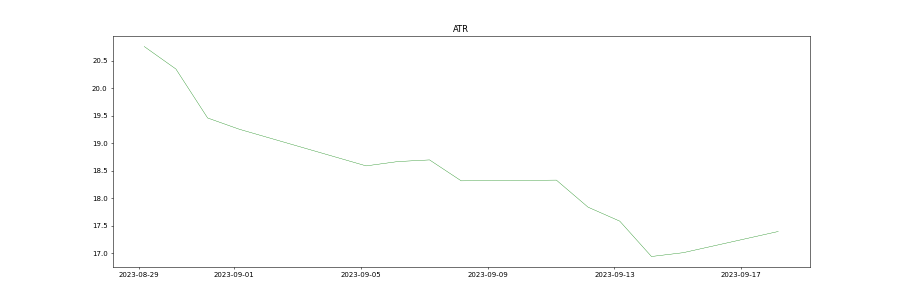

In [53]:
plot_graph(atr[s-pd.DateOffset(days=5):e+pd.DateOffset(days=2)], 'ATR')

I've identified four days of interest, 2/22 and low and behold, on that day we made 9000$. Interesting. It seems that when ATR is increasing we tend to make more money, but when it's decreasing we tend to lose money. Let's test this elaborated hypothesis.

In [18]:
# Let's only test these after Jan 2 so we don't have to pull data
results = tuning(symbols, list(atr[tk.d(1,2):][atr.diff()>0].index+pd.DateOffset(days=1)), False, False, True)

1/3 Wednesday -194.33 		 0
skipping 2024-01-06 05:00:00+00:00
1/9 Tuesday -4177.36 		 -194.33
1/10 Wednesday -916.25 		 -4371.69
1/12 Friday -410.11 		 -5287.94
1/17 Wednesday -1639.1 		 -5698.05
1/18 Thursday -537.95 		 -7337.15
1/19 Friday -1296.91 		 -7875.1
skipping 2024-01-20 05:00:00+00:00
1/25 Thursday -1264.16 		 -9172.0
1/26 Friday 1627.3 		 -10436.16
2/1 Thursday -811.33 		 -8808.86
2/2 Friday -2820.87 		 -9620.19
skipping 2024-02-03 05:00:00+00:00
2/6 Tuesday -2859.78 		 -12441.06
2/7 Wednesday -2939.83 		 -15300.84
2/8 Thursday -212.3 		 -18240.66
skipping 2024-02-10 05:00:00+00:00
2/13 Tuesday 2557.19 		 -18452.97
2/14 Wednesday 1466.35 		 -15895.78
2/15 Thursday 660.18 		 -14429.43
2/21 Wednesday 1035.66 		 -13769.25
2/22 Thursday 10403.78 		 -12733.59
2/23 Friday -983.5 		 -2329.81
skipping 2024-02-24 05:00:00+00:00
skipping 2024-03-02 05:00:00+00:00
3/5 Tuesday -500.83 		 -3313.31
3/7 Thursday -619.76 		 -3814.14
3/8 Friday 8294.62 		 -4433.9
skipping 2024-03-09 05:00:0

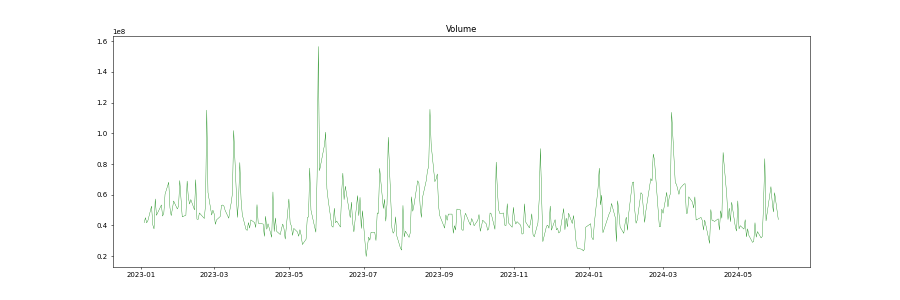

In [19]:

plot_graph(volume, 'Volume')

# Ruminating on Our Present Predicament
I must gather a greater understanding of the mechanics at play. I must gather my thoughts on the root of our ills. Here is the problem: squeeze momentum has a tendency to enter at the worst possible time, i.e, after the majority of movement has already taken play. I thought perhaps that by reducing the pip interval we could counteract this flaw, essentially listening to the movement of things and reacting before others have the necessary data to follow suit. However, I fear this may have simply made us vulnerable to yet more false starts and stops. How can we remedy this? I must contemplate this problem, and seek out more information on other methods and procedures.
### Further Difficulties
I keep getting psyched out by everything. I swear I can't work when I'm worried about moneybot. Perhaps we should go back to paper, but paper showed good performance, so again, maybe I need to calm down and not get so flighty.
### Our Next Steps
1. Finish work on the trend estimation function
2. Implement more technical indicators
3. Continue watching various tutorials
### What do we Know?
We know the basics of what a candle stick is, about what trades are, about tell-tale signs, about market movements. We could investigate the specifics of many things, we could see this or that thing. I'm certain that the increase in performance when we don't filter is due to sometimes trading on those massive spikes (which wouldn't happen in real life), but maybe those spikes could tell us something, yes? It may well be worth looking for those massive spikes in the trade data, and seeing if they immediately lead to any different behavior.

# Post Spike Behavior Analysis
Before we get into the main course of today's lecture, let's take a quick break to analyze the behavior of stocks following a massive spike. If we can find a trend we can use it to our advantage.
### OIHPER
1. Observation: Large spikes occur (probably from industry trades making massive orders).
2. Inquiry: Do these large spikes predict market behavior in their immediate aftermath.
3. Hypothesis: These large movements are signals that others (including me) will follow.
4. Prediction: I can make profit purely from jumping on the bandwagon.
5. Experiment: I will comb through the data to find these spikes and then see if there's a clear action after them.

In [3]:
# Pull ALL Data
base_data = sc.get_archive('GOOG')
print(base_data.index[0], base_data.index[-1])

2024-05-08 09:31:00-04:00 2024-05-30 10:43:00-04:00


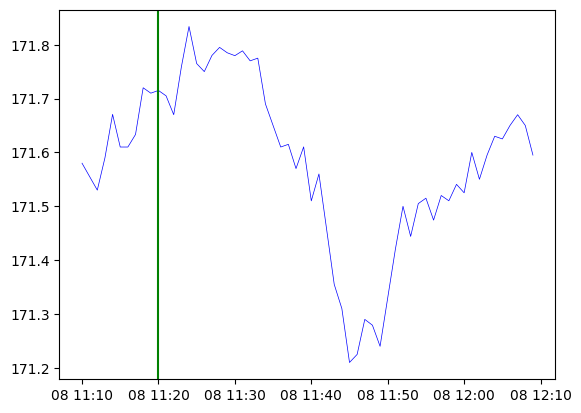

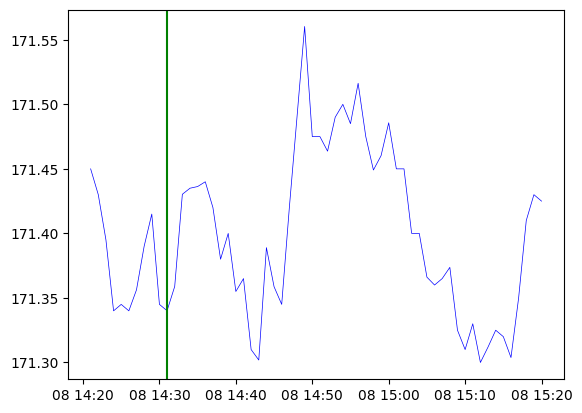

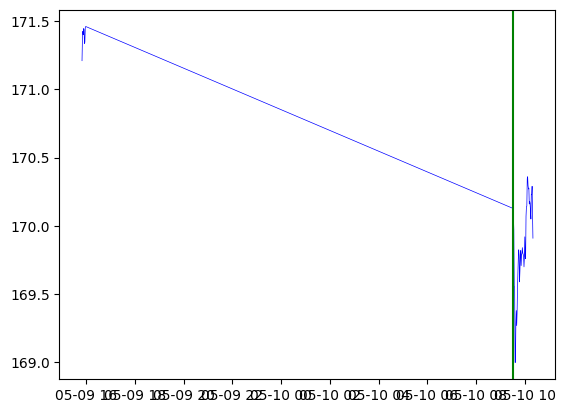

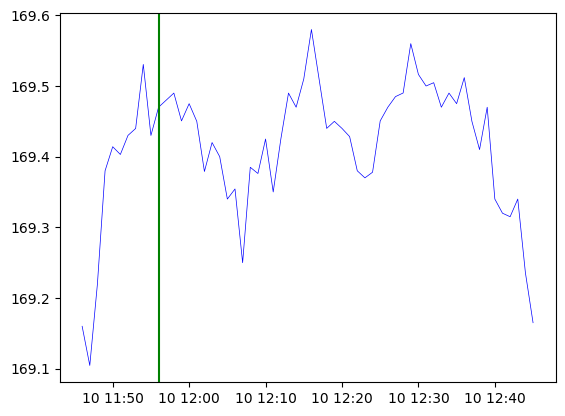

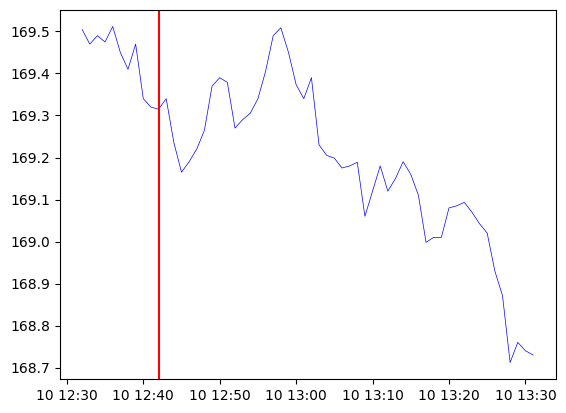

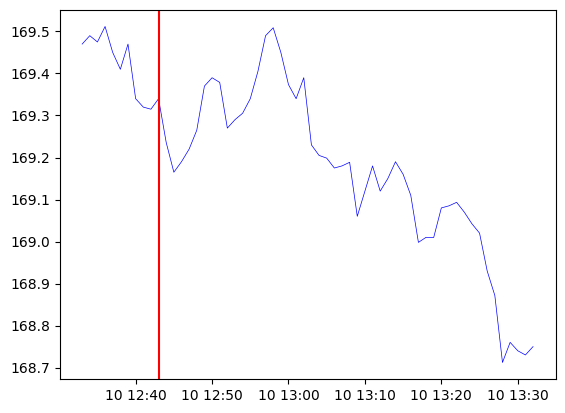

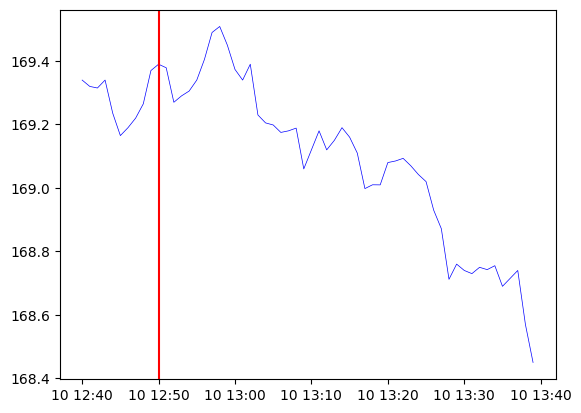

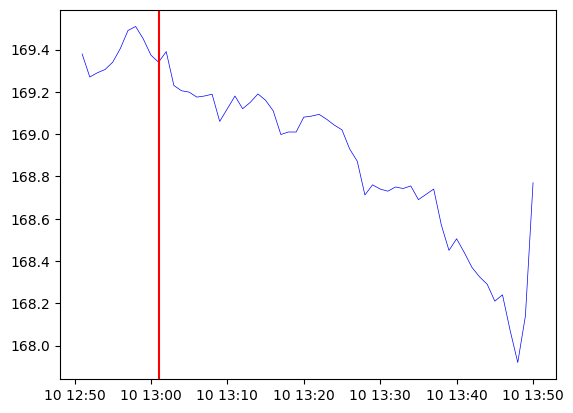

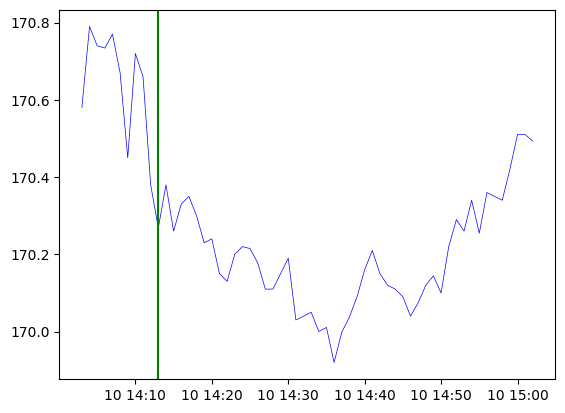

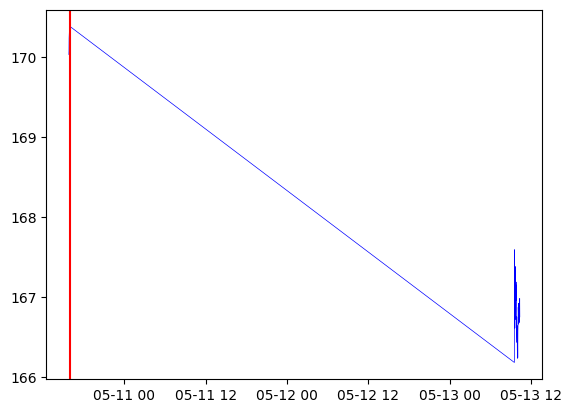

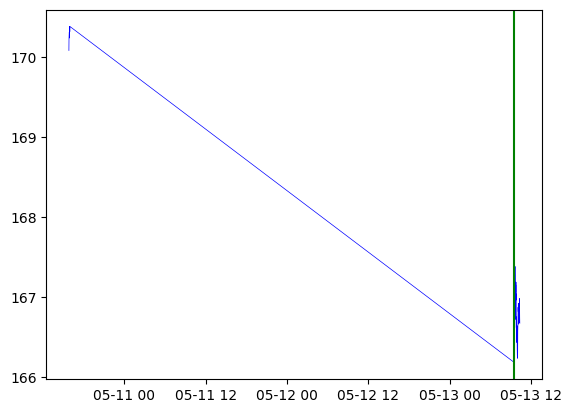

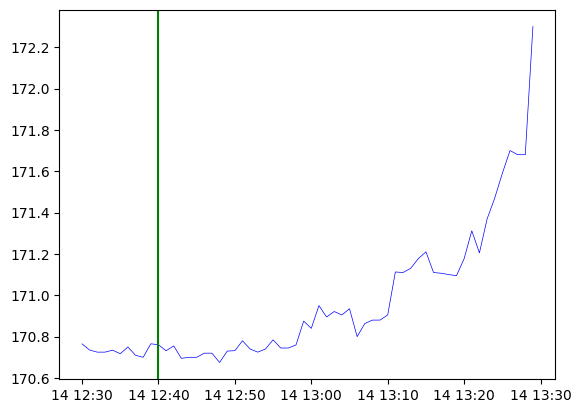

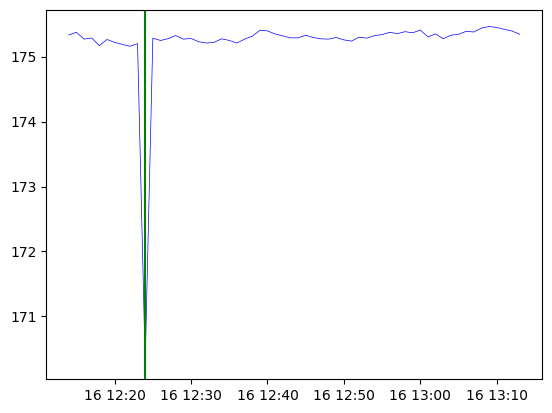

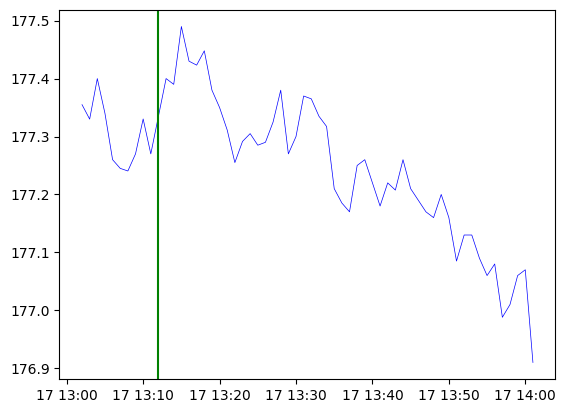

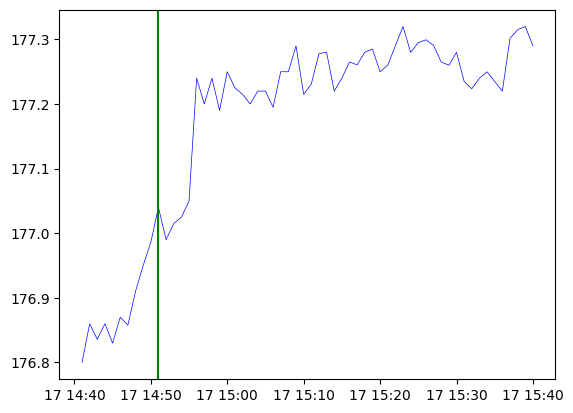

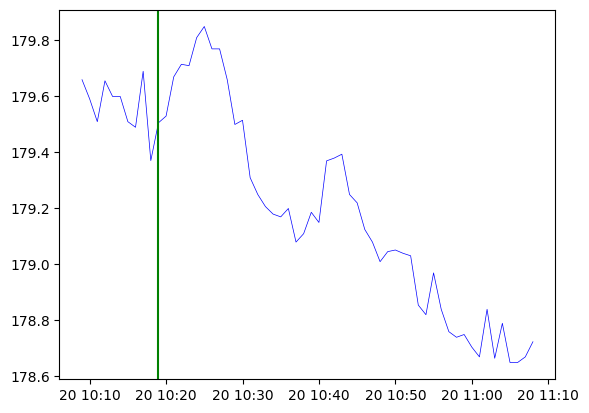

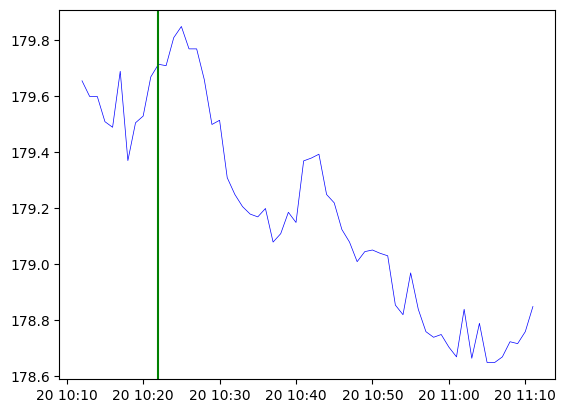

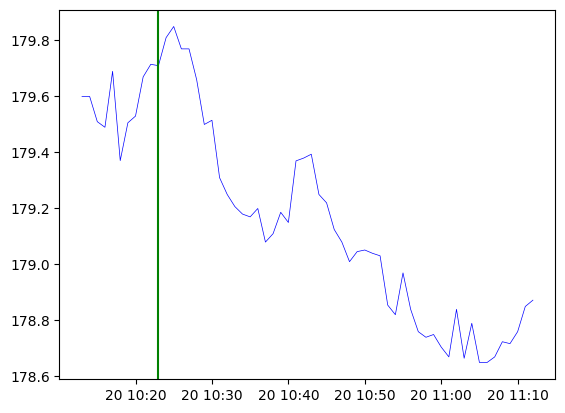

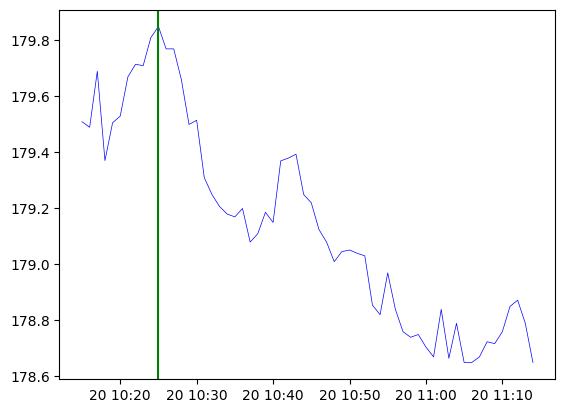

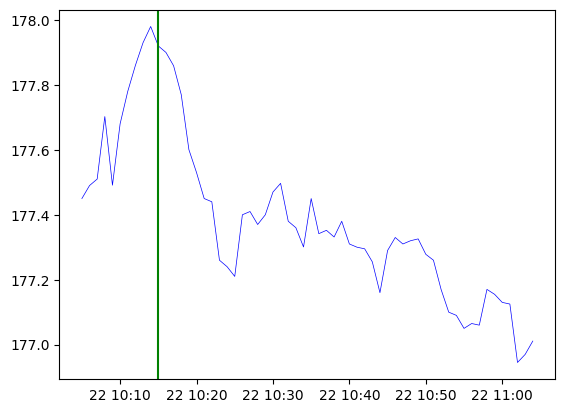

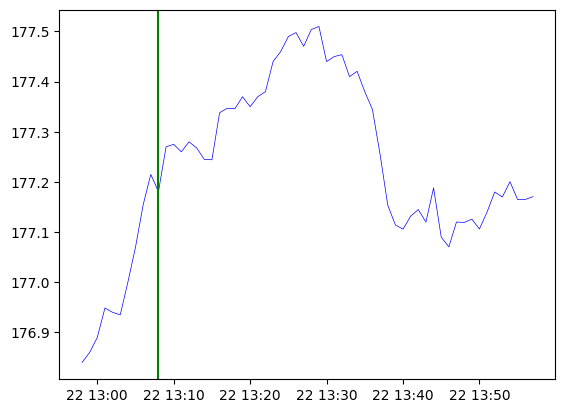

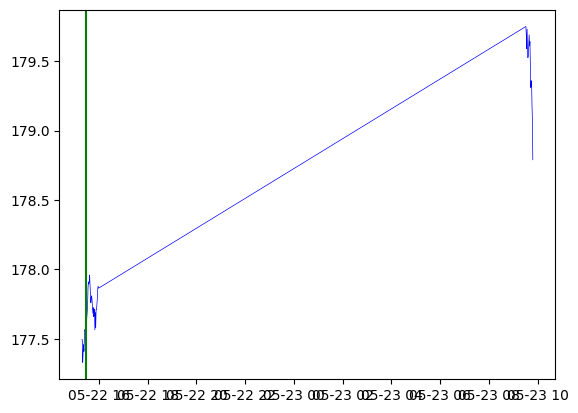

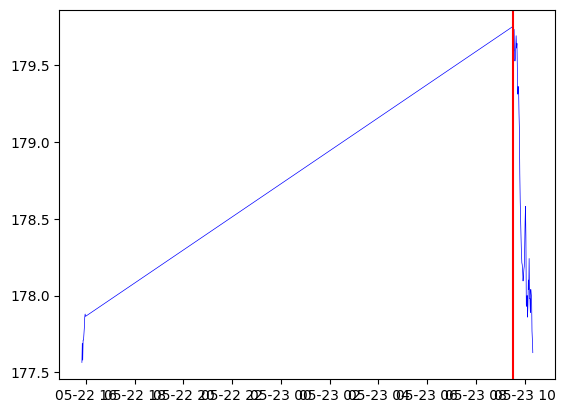

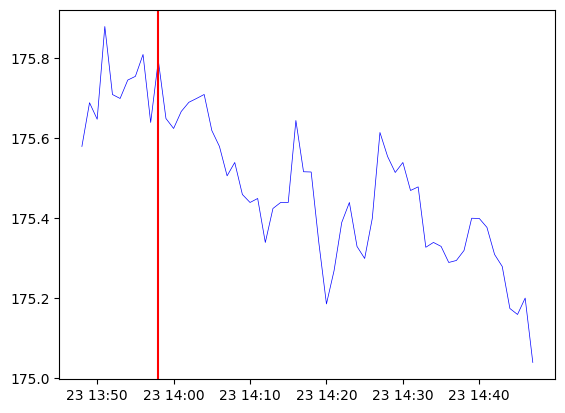

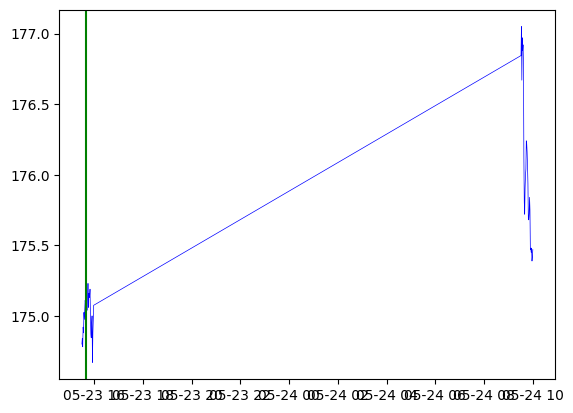

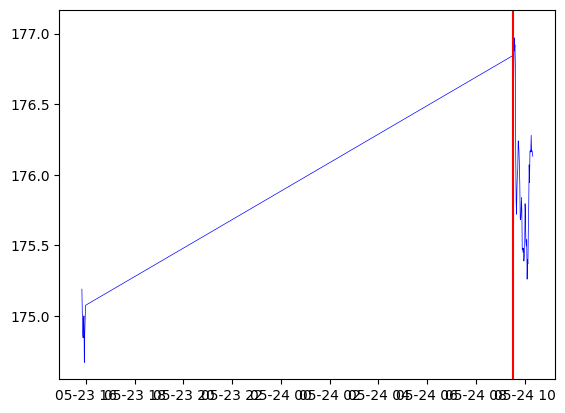

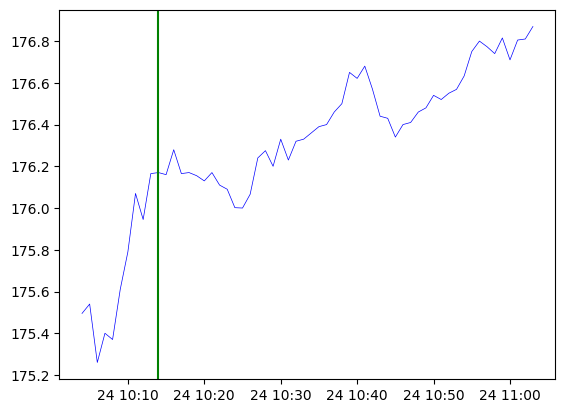

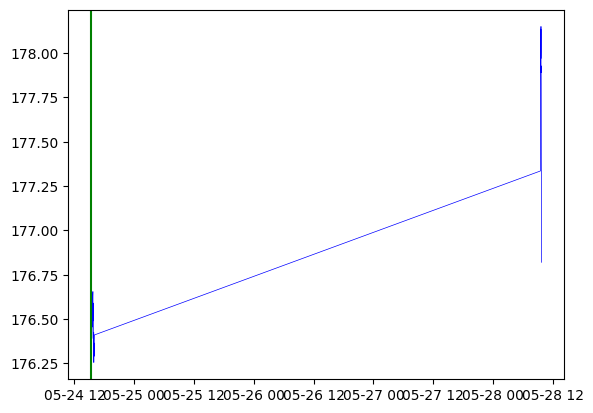

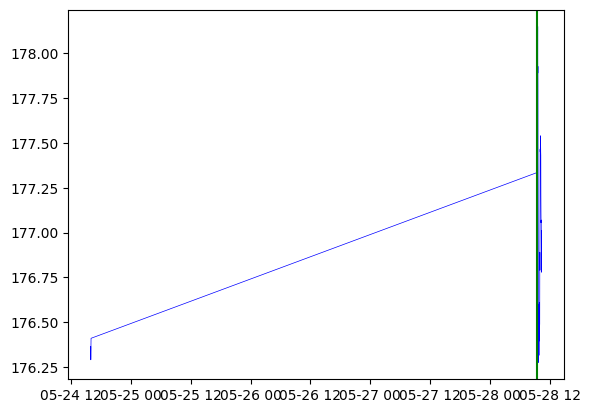

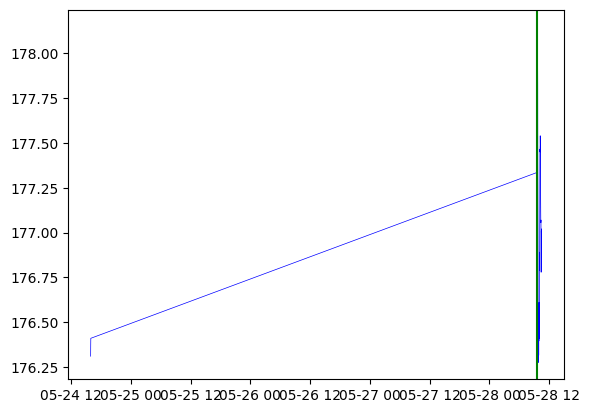

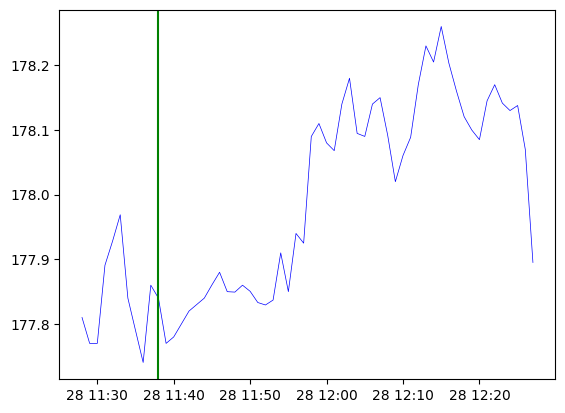

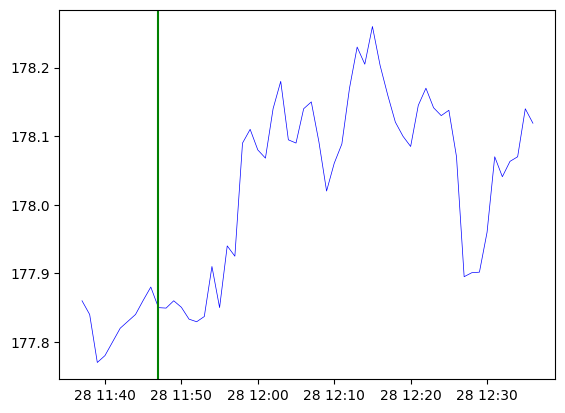

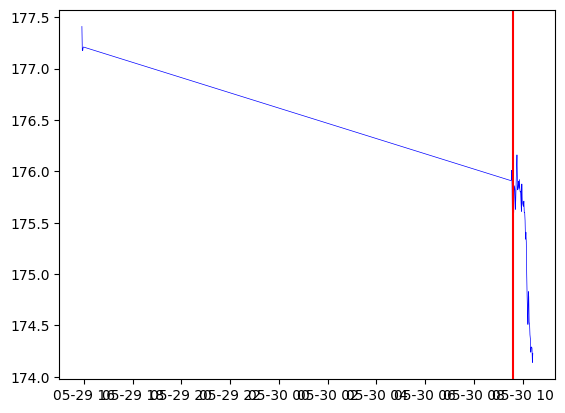

0.6363636363636364 33


In [7]:
# df = base_data[tk.d(5,30):]
df = base_data
spikes, factor, lookforward = [], .01, 50
accurate = 0
for i in range(len(df))[1:-1]:
    entry, prev_entry, next_entry = df.iloc[i], df.iloc[i-1], df.iloc[i+1]
    high_spike, low_spike = (entry.high > prev_entry.high * (1+factor) or entry.high > next_entry.high * (1+factor)), (entry.low < prev_entry.low * (1-factor) or entry.low < next_entry.low * (1-factor))
    if not (high_spike or low_spike): continue
    spikes.append(i)
    delta = df.iloc[i:i+lookforward].close.diff().sum()

    # Signal that we should fall
    if high_spike and delta < 0: accurate += 1
    # Signal that we should rise
    if low_spike and delta > 0: accurate += 1

    if i > (len(df) - lookforward): continue
    span = df.iloc[i-10:i+lookforward]
    #tb.candle_plot(span, 10, 10, show=True)
    tb.qp(span.close, color='blue')
    if low_spike: plt.axvline(df.index[i], color='green')
    elif high_spike: plt.axvline(df.index[i], color='red')
    plt.show()

print(accurate/len(spikes), len(spikes))

## Reflection
It seems that spikes between .01 and .5 are predictive roughly 58% of the time, and spikes of .1 were predictive a promising 68% of the time, however such spikes only occured 50 times over the entire run of NVDA 2024 and thus can't be relied on as market indicators. Shockingly, in the extremely small span of GOOG we've collected (May 8 through May 30) we saw 50 spikes which were accurate 63% of the time. This suggests that spikes may be highly symbol dependent, and may prove useful for some symbols but not others.

In [2]:
data = sc.get_processed_archive('nvda', tk.d(6,3))
print(len(data))

2340


In [5]:
atr = tb.get_atr(data)
atr_plus = data.close + atr
atr_minus = data.close - atr

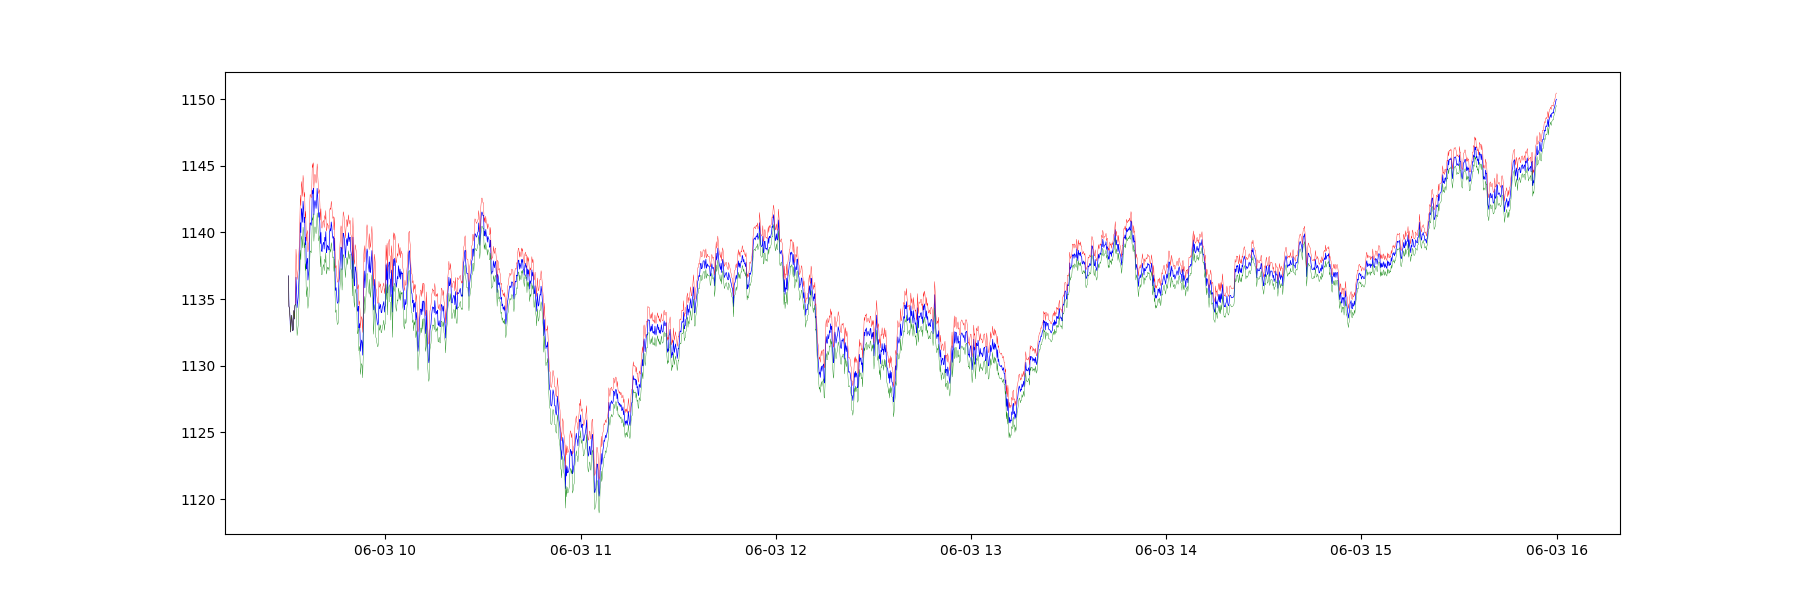

In [10]:
%matplotlib widget
plt.figure(figsize=(18, 6), dpi=100)
tb.qp(data.close, 'blue', .5)
tb.qp(atr_plus, 'red', .25)
tb.qp(atr_minus, 'green', .25)
plt.show()

# PATHS OF INVESTIGATION
1. Once again we could look at the morning, basically saying "every morning we are guaranteed to have movement of a certain amount" from the opening price. We then try to buy at the opening price and exit once we reach the expected change.
2. Something to do with ATR, sort of treating ATR like bollinger bands. If an entry's close is close to the the previous entry's atr (either plus or minus) then we buy or short sell. Basically saying "if it pops off, we immediately follow it."
3. Something to do with pairing a long squeeze momentum with a short squeeze momentum. The problem with squeezemomentum has always been the fact that we enter the market after the trend has clearly had it's time, but squeeze is still the most reliable way of predicting the market. Therefore, let's use a facet of squeeze momentum to stop us from making dumb traces, that being a longer scale sm.
4. Master the fundamentals: This is something we need to do at some point no matter what, but we need to sit down and get a handle on market structure, volatility, and momentum, and understand how long term behavior can help save us from short term losses.

Think about what we need to do for stuff
1. Revert from bars to trade
2. Figure out how to Use big trade spikes to our advantage rather than losing money on them (keep the information it might be useful).
3. Understand the market conditions and whether the movement of the S&P or tech bundles effects the next day's behavior (or current behavior)
4. Run the ARIMA on larger scale data like hourly or daily or weekly
5. Look up tutorials on this subject and learn from them (specifically algo-trading).

# Performance in First Hour NVDIA

In [3]:
hours = sc.get_bars('NVDA', tk.d(1,2,year=2023), tk.today(), alp.TimeFrame.Hour)

Activating with Paper
Pulling trades from 2023-01-02T00:00:00-04:00 to 2024-06-09T00:00:00-04:00


In [14]:
all_our_mornings = hours[hours.index.hour == 10]
ophi = (all_our_mornings.high - all_our_mornings.open)
oplo =  (all_our_mornings.open - all_our_mornings.low)
print('OPEN TO HIGH', ophi.mean(), ophi.min())
print('OPEN TO LOW', oplo.mean(), oplo.min())

OPEN TO HIGH 4.093318611111115 0.03000000000002956
OPEN TO LOW 4.089464444444445 0.0
